In [ ]:
from database.database import get_session, MediumArticle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bertopic import BERTopic
from transformers import BertTokenizer, BertModel
import numpy as np
import torch
from tqdm.notebook import tqdm
# import rich progressbar
from rich.progress import track
from rich.progress import Progress

# Setup device - properly configure MPS for Apple Silicon
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

sns.set(style="whitegrid")
sns.set_context(
    "paper",
    rc={
        "font.size": 8,
        "axes.titlesize": 10,
        "axes.labelsize": 8,
        "fig.title_size": 13,
    },
)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Using device: mps


In [87]:
all_articles = get_session().query(MediumArticle).all()
len(all_articles)

969

In [88]:
# to pandas
df = pd.read_sql_query(
    get_session().query(MediumArticle).statement,
    get_session().bind,
    index_col="id",
)
df.head()

,url_id,title,author_id,date_published,date_modified,date_created,description,publisher_type,is_free,claps,comments_count,full_article_text,read_time,type,num_images,tags
id,,,,,,,,,,,,,,,,
2,29571399,Hexagonal Architecture with Dotnet 6 — Part 2:...,2,2022-10-06 05:03:47.821,2022-10-09 05:59:49.460,2022-10-06 05:03:47.821,We go to Visual Studio and click “Create a new...,Organization,True,3,0,We go to Visual Studio and click “Create a new...,2,NewsArticle,2,"[Dotnet, Hexagonal Architecture, Cqrs, Ddd]"
4,29571469,Why Scotland’s Muslim Women Should be Followin...,6,2022-10-06 23:44:10.874,2022-10-07 00:53:47.320,2022-10-06 23:44:10.874,Picture this: It is 11pm and you stop at a ser...,Organization,True,50,1,And how to do it…\n\n![](https://miro.medium.c...,5,NewsArticle,3,"[Gender, Transgender, Scotland, Law, Muslim]"
5,29571486,Mongodb Relational Documents with Node.js and ...,8,2022-10-06 06:07:42.984,2022-10-09 10:10:56.185,2022-10-06 06:07:42.984,As a beginner many people are confused on how ...,Organization,True,2,0,![](https://miro.medium.com/v2/resize:fit:1400...,5,NewsArticle,9,"[Mongodb, Mongoose, Database, Nodejs, Mongodb ..."
6,29571441,Morpheus.Network Kickstarts KYC For Beta Maste...,9,2022-10-06 20:59:22.106,2024-02-20 21:25:06.545,2022-10-06 20:59:22.106,We’re thrilled to announce that the first stag...,Organization,True,410,2,![](https://miro.medium.com/v2/resize:fit:700/...,5,NewsArticle,6,[]
7,29571501,Why Having an Affair is Easy Until It Isn’t - ...,12,2022-10-06 07:12:37.354,2024-01-08 20:40:38.553,2022-10-06 07:12:37.354,When you get married you make covenants and vo...,Organization,True,142,1,![](https://miro.medium.com/v2/1*jE2H3k-Lk49Do...,7,NewsArticle,3,"[Infidelity, Love, Marriage, Divorce, Mental H..."


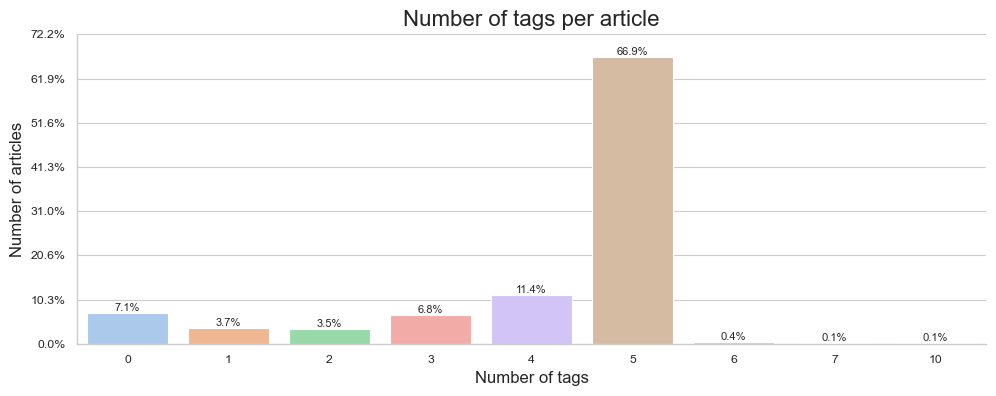

In [89]:
# Create a new Series with the number of tags per article
tag_counts = df["tags"].apply(len)

# Calculate percentages for each count
total_articles = len(df)
value_counts = tag_counts.value_counts()
percentages = (value_counts / total_articles) * 100

# Create a seaborn plot to show tag count distribution
plt.figure(figsize=(10, 4))

# Fix the countplot with proper parameter usage
ax = sns.countplot(x=tag_counts, hue=tag_counts, palette="pastel", legend=False)
ax.set_title("Number of tags per article", fontsize=16)
ax.set_xlabel("Number of tags", fontsize=12)
ax.set_ylabel("Number of articles", fontsize=12)

# Add percentage labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total_articles) * 100
    ax.annotate(f'{percentage:.1f}%', 
                (p.get_x() + p.get_width()/2., height), 
                ha='center', va='bottom')

# Fix y-axis ticks to show percentages properly
y_ticks = ax.get_yticks()
ax.set_yticks(y_ticks)  # First set the tick positions
ax.set_yticklabels([f'{(y/total_articles)*100:.1f}%' for y in y_ticks])

# Improve readability of labels
sns.despine()
plt.tight_layout()
plt.show()

From now on we only consider those articles with at least one tag.

In [90]:
# delete all articles without tags
df = df[df["tags"].apply(len) > 0]
df.shape

(900, 16)

In [91]:
df.head()

,url_id,title,author_id,date_published,date_modified,date_created,description,publisher_type,is_free,claps,comments_count,full_article_text,read_time,type,num_images,tags
id,,,,,,,,,,,,,,,,
2,29571399,Hexagonal Architecture with Dotnet 6 — Part 2:...,2,2022-10-06 05:03:47.821,2022-10-09 05:59:49.460,2022-10-06 05:03:47.821,We go to Visual Studio and click “Create a new...,Organization,True,3,0,We go to Visual Studio and click “Create a new...,2,NewsArticle,2,"[Dotnet, Hexagonal Architecture, Cqrs, Ddd]"
4,29571469,Why Scotland’s Muslim Women Should be Followin...,6,2022-10-06 23:44:10.874,2022-10-07 00:53:47.320,2022-10-06 23:44:10.874,Picture this: It is 11pm and you stop at a ser...,Organization,True,50,1,And how to do it…\n\n![](https://miro.medium.c...,5,NewsArticle,3,"[Gender, Transgender, Scotland, Law, Muslim]"
5,29571486,Mongodb Relational Documents with Node.js and ...,8,2022-10-06 06:07:42.984,2022-10-09 10:10:56.185,2022-10-06 06:07:42.984,As a beginner many people are confused on how ...,Organization,True,2,0,![](https://miro.medium.com/v2/resize:fit:1400...,5,NewsArticle,9,"[Mongodb, Mongoose, Database, Nodejs, Mongodb ..."
7,29571501,Why Having an Affair is Easy Until It Isn’t - ...,12,2022-10-06 07:12:37.354,2024-01-08 20:40:38.553,2022-10-06 07:12:37.354,When you get married you make covenants and vo...,Organization,True,142,1,![](https://miro.medium.com/v2/1*jE2H3k-Lk49Do...,7,NewsArticle,3,"[Infidelity, Love, Marriage, Divorce, Mental H..."
11,29571511,Building responsive Flutter desktop and web ap...,31,2022-10-06 00:12:53.310,2022-12-08 12:06:54.192,2022-10-06 00:12:53.310,Flutter has grown over the years. compared wit...,Organization,True,64,2,![](https://miro.medium.com/v2/resize:fit:1400...,3,NewsArticle,3,"[Flutter, Responsive Design, Desktop, Web]"


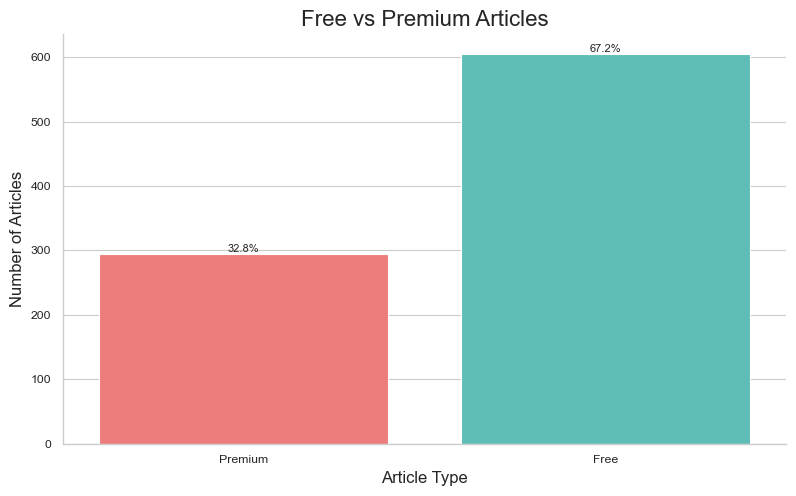

In [92]:
# Count free vs premium articles
free_premium_counts = df['is_free'].value_counts()
free_premium_percentages = (free_premium_counts / len(df)) * 100

# Create figure
plt.figure(figsize=(8, 5))

# Create bar plot with proper hue parameter to avoid the warning
ax = sns.countplot(x='is_free', hue='is_free', data=df, palette=["#ff6b6b", "#4ecdc4"], legend=False)
ax.set_title("Free vs Premium Articles", fontsize=16)
ax.set_xlabel("Article Type", fontsize=12)
ax.set_ylabel("Number of Articles", fontsize=12)

# Set more readable x-axis labels
ax.set_xticks([0, 1])  # Set the tick positions
ax.set_xticklabels(['Premium', 'Free'])

# Add percentage labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    percentage = (height / len(df)) * 100
    ax.annotate(f'{percentage:.1f}%', 
                (p.get_x() + p.get_width()/2., height), 
                ha='center', va='bottom')

# Improve readability of labels
sns.despine()
plt.tight_layout()
plt.show()

In [93]:
tags = df["tags"].apply(lambda x: [tag.lower() for tag in x])
tags.iloc[30]

['year in review', 'digital agency', 'remote team', '2021', 'pandemic diaries']

In [94]:
model = BertModel.from_pretrained('bert-base-multilingual-cased')
# Move model to MPS device
model = model.to(device)

def get_tag_embeddings(article: MediumArticle):
    """
    Get the tag embeddings for a given article.
    """
    # Tokenize the tags
    tokens = tokenizer(article.tags, padding=True, truncation=True, return_tensors="pt")
    
    # Move tokens to device
    tokens = {k: v.to(device) for k, v in tokens.items()}
    
    # Get the embeddings
    with torch.no_grad():
        outputs = model(**tokens)
    
    # Get the mean of the last hidden state and move back to CPU for numpy
    embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
    
    return embeddings

get_tag_embeddings(df.iloc[0]).shape

(4, 768)

In [95]:
def get_article_embedding(article: MediumArticle):
    text = article.full_article_text
    tokens = tokenizer.tokenize(text)
    max_tokens = 510
    if len(tokens) > max_tokens:
        embeddings = []
        for i in range(0, len(tokens), max_tokens):
            chunk_tokens = tokens[i:i + max_tokens]
            chunk_text = tokenizer.convert_tokens_to_string(chunk_tokens)
            inputs = tokenizer(chunk_text, return_tensors="pt", padding=True, truncation=True)
            # Move inputs to device
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            with torch.no_grad():
                outputs = model(**inputs)
            # Move back to CPU for numpy
            chunk_embedding = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            embeddings.append(chunk_embedding)
        return np.mean(embeddings, axis=0)
    else:
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        # Move inputs to device
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = model(**inputs)
        # Move back to CPU for numpy
        return outputs.last_hidden_state.mean(dim=1).cpu().numpy()

get_article_embedding(df.iloc[0]).shape

(1, 768)

In [96]:
# calc differences between article and tags
def calc_differences(article_embedding, tag_embeddings):
    differences = []
    for tag_embedding in tag_embeddings:
        # Calculate the difference
        diff = article_embedding - tag_embedding
        # Calculate the norm (magnitude) of the difference
        norm = np.linalg.norm(diff)
        differences.append(norm)
    return differences

calc_differences(
    get_article_embedding(df.iloc[0]),
    get_tag_embeddings(df.iloc[0])
)

[np.float32(11.191925),
 np.float32(12.227882),
 np.float32(10.8644085),
 np.float32(12.5302105)]

In [ ]:
# Calculate differences for all articles, then average them and plot the differences between free and premium using a bar plot
all_differences = []

# Create a progress display
with Progress() as progress:
    # Create a task with appropriate description
    task = progress.add_task("[cyan]Calculating article-tag differences...", total=len(df))
    
    for article in df.itertuples():
        tag_embeddings = get_tag_embeddings(article)
        article_embedding = get_article_embedding(article)
        differences = calc_differences(article_embedding, tag_embeddings)
        all_differences.append(np.mean(differences))
        
        # Update progress
        progress.update(task, advance=1)

# Add differences to dataframe
df["differences"] = all_differences
df["differences"].head()

Output()

In [ ]:
# Group by is_free and calculate mean differences
free_premium_diff = df.groupby('is_free')['differences'].mean().reset_index()

# Create figure
plt.figure(figsize=(10, 6))

# Create bar plot
ax = sns.barplot(x='is_free', y='differences', data=free_premium_diff, palette=["#ff6b6b", "#4ecdc4"])
ax.set_title("Average Semantic Distance Between Articles and Their Tags", fontsize=16)
ax.set_xlabel("Article Type", fontsize=14)
ax.set_ylabel("Average Difference (Semantic Distance)", fontsize=14)

# Set more readable x-axis labels
ax.set_xticks([0, 1])
ax.set_xticklabels(['Premium', 'Free'])

# Add value labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width()/2., p.get_height()), 
                ha='center', va='bottom', fontsize=12)

# Statistical test to check if the difference is significant
from scipy import stats

# Get differences for free and premium articles
premium_diffs = df[df['is_free'] == False]['differences']
free_diffs = df[df['is_free'] == True]['differences']

# Perform t-test
t_stat, p_val = stats.ttest_ind(premium_diffs, free_diffs, equal_var=False)

# Add annotation with p-value
plt.annotate(f'p-value: {p_val:.4f}', xy=(0.5, 0.9), xycoords='axes fraction', 
             ha='center', va='center', fontsize=12, 
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.3))

# Add interpretation
if p_val < 0.05:
    plt.annotate('Statistically significant difference', xy=(0.5, 0.85), 
                 xycoords='axes fraction', ha='center', va='center', 
                 fontsize=10, color='green')
else:
    plt.annotate('No statistically significant difference', xy=(0.5, 0.85), 
                 xycoords='axes fraction', ha='center', va='center', 
                 fontsize=10, color='red')

# Improve readability of labels
sns.despine()
plt.tight_layout()
plt.show()

# Display descriptive statistics
print("\nDescriptive Statistics:")
premium_stats = premium_diffs.describe()
free_stats = free_diffs.describe()

# Create a DataFrame to display side by side
stats_df = pd.DataFrame({
    'Premium Articles': premium_stats,
    'Free Articles': free_stats
})
stats_df

In [ ]:
# Explore tag distribution across free and premium articles

# Get all unique tags
all_tags = set()
for tags_list in df['tags']:
    all_tags.update(tags_list)

print(f"Total unique tags: {len(all_tags)}")

# Find most common tags in premium vs free articles
premium_articles = df[df['is_free'] == False]
free_articles = df[df['is_free'] == True]

# Count tag frequencies
from collections import Counter

def get_tag_freq(articles_df):
    tag_counter = Counter()
    for tags_list in articles_df['tags']:
        tag_counter.update(tags_list)
    return tag_counter

premium_tag_freq = get_tag_freq(premium_articles)
free_tag_freq = get_tag_freq(free_articles)

# Get top 15 tags for each category
top_premium_tags = pd.DataFrame(premium_tag_freq.most_common(15), columns=['Tag', 'Count'])
top_free_tags = pd.DataFrame(free_tag_freq.most_common(15), columns=['Tag', 'Count'])

# Calculate percentage
top_premium_tags['Percentage'] = (top_premium_tags['Count'] / len(premium_articles)) * 100
top_free_tags['Percentage'] = (top_free_tags['Count'] / len(free_articles)) * 100

# Display results
print("\nTop 15 tags in Premium articles:")
display(top_premium_tags)

print("\nTop 15 tags in Free articles:")
display(top_free_tags)

# Create visualizations of tag distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Premium tags
sns.barplot(x='Tag', y='Percentage', data=top_premium_tags.head(10), ax=ax1, palette='Reds_d')
ax1.set_title('Top 10 Tags in Premium Articles', fontsize=14)
ax1.set_xlabel('Tag', fontsize=12)
ax1.set_ylabel('Percentage of Premium Articles (%)', fontsize=12)
ax1.tick_params(axis='x', rotation=45)

# Free tags
sns.barplot(x='Tag', y='Percentage', data=top_free_tags.head(10), ax=ax2, palette='Blues_d')
ax2.set_title('Top 10 Tags in Free Articles', fontsize=14)
ax2.set_xlabel('Tag', fontsize=12)
ax2.set_ylabel('Percentage of Free Articles (%)', fontsize=12)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Calculate Jaccard similarity between tag sets
premium_tags_set = set(premium_tag_freq.keys())
free_tags_set = set(free_tag_freq.keys())

intersection = premium_tags_set.intersection(free_tags_set)
union = premium_tags_set.union(free_tags_set)

jaccard_similarity = len(intersection) / len(union)

print(f"\nTags overlap analysis:")
print(f"Tags only in premium articles: {len(premium_tags_set - free_tags_set)}")
print(f"Tags only in free articles: {len(free_tags_set - premium_tags_set)}")
print(f"Tags in both categories: {len(intersection)}")
print(f"Total unique tags: {len(union)}")
print(f"Jaccard similarity coefficient: {jaccard_similarity:.4f}")
